<table>
    <tr>
        <td>
            <h2 align="center">Немного о проделанной работе</h2><br><br>
            <p>Озвученная ментором цель: "улучшить данный baseline" достаточно проста. Этого можно достичь с помощью трёх параметров - "Ranking", "Number of Reviews" и "id_g" даже не применяя округление. В данной работе удалось добиться результата ошибки, меньшего 0,14.</p>
            <p>Были введены дополнительные параметры, в том числе, полученные исходя из открытых статистик (например, численность населения городов) и из акутальных карточек ресторанов на TripAdvisor (например, текущий "Ranking"). Входные данные были собраны в файлы all_train_data.csv и all_test_data.csv. Эти файлы соответствуют main_task.csv и kaggle_task.csv, но содержат также данные, полученные из TripAdvisor.</p>
            <p>Я предложил группе взять у меня данные, собранные на TripAdvisor. На данный момент ко мне обратился один человек, которому я их выслал.</p>
            <p>Всё, что представлено ниже - моя собственная работа. Идея, которой я доволен больше всего - округление результата предсказаний до половины целого. Это позволяет от результата 0,175 прийти к результату 0,14. До диапазона 0,14-0,15 удалось дойти за пять попыток, остальные - исследования, в основном.</p>
            <p>Остались непонятны следующие вещи:</p>
            <ul style="text-align:left;">
                <li>Каков должен быть баланс между количеством параметров модели и её эффективностью? Можно сделать модель с сотней параметров, которая будет на целую десятую точнее модели на пять параметров. Это того стоит? Какие есть метрики или критерии в данном случае?</li>
                <li>Почему мы используем для предсказания параметр "Ranking", который, очевидно, сам по себе формируется исходя из целевой "Rating"? Если исключить все параметры, которые косвенно связаны с "Rating", уровень предсказания падает до значений типа 0,44 (без округления). Это не то чтобы далеко ушло от результата тренировки на случайном массиве (0,62).</li>
                <li>Как распарсить "Reviews" более красиво?</li>
                <li>Как формировать признаки типа массива "n" не в ручном режиме, а в автоматическом?</li>
                <li>Заполнение NaN с помощью созданной для этого модели не показывает более хороших результатов по сравнению с заполнением медианой. Почему?</li>
            </ul>
        </td>
    </tr>
</table>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from ast import literal_eval
import math
import re
import datetime
from datetime import datetime
import itertools
from collections import Counter
from textblob import TextBlob

pd.set_option("display.max_columns", 50)

In [2]:
# Хотим моделировать для замены NaN или нет?
need_model = 0

In [3]:
# Функция, тренирующая модель n раз
def train_model(x, y, n, seed_v, est):

    min_error = 1e6
    max_error = -1e6
    mean_error = 0
    best_regr = RandomForestRegressor(n_estimators=est, n_jobs=-1)

    for i in range(n):

        seed = seed_v[i]

        X_train, X_test, y_train, y_test = train_test_split(
            x, y, test_size=0.25)
        regr = RandomForestRegressor(n_estimators=est, n_jobs=-1)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        curr_error = metrics.mean_absolute_error(y_test, y_pred)

        mean_error += curr_error

        if curr_error < min_error:
            min_error = curr_error
            best_regr = regr

        if curr_error > max_error:
            max_error = curr_error

    mean_error /= n

    return mean_error, min_error, max_error, best_regr


# Функция, превращающая столбцец "Price Range" в числовой
def price_rate(price):
    if price == "$":
        return 1
    elif price == "$$ - $$$":
        return 2
    elif price == "$$$$":
        return 3
    elif price == "":
        return NaN

# Изначально - функция, которая тренирует модель со всеми сочетания столбцов из x_cols
#  Позже была добавлена возможность установить pairs=0, и тренировать только на полном наборе x_cols


def search_best(df, x_cols, y_col, x_add, fill, num_tests, seed, trees, real_work, pairs=1):

    if real_work == 0:
        print("Тестовый прогон в целях экономии времени")
        return 1, 1

    if fill == "drop":
        data2 = df.dropna()
    elif fill == "mean":
        data2 = df.fillna(df.mean())
    elif fill == "no need":
        data2 = df.copy()
    else:
        data2 = df.fillna(df.median())

    y = data2[y_col]

    i = 0

    if pairs == 0:

        plain_col = list(itertools.chain(*x_cols))
        X = data2[plain_col].copy()
        mean_error, min_error, max_error, best_regr = train_model(
            X, y, n_attempts, seed_v, trees)
        s = "{0}. Тестируется {1}. Средняя ошибка: {2:.4f}.".format(
            i, plain_col, mean_error)
        print(s)
        return best_regr, X

    for l in range(0, len(x_cols)+1):
        for col in itertools.combinations(x_cols, l):

            if i == 0:
                i += 1
                if len(x_add) == 0:
                    continue
                if len(x_add) > 1:
                    x_add = list(itertools.chain(*x_add))
                continue

            i += 1

            plain_col = list(itertools.chain(*col))

            for elem in x_add:
                plain_col.append(elem)

            X = data2[list(plain_col)].copy()
            mean_error, min_error, max_error, best_regr = train_model(
                X, y, n_attempts, seed_v, trees)
            s = "{0}. Тестируется {1}. Средняя ошибка: {2:.4f}.".format(
                i, plain_col, mean_error)
            print(s)

    return best_regr, X


# Функция замены nan
def replace_nan(df, col, what):
    nans = df[col].isnull()
    df.loc[nans, col] = [what for isnan in nans.values if isnan]
    return df


# Функция создания dummy-переменных
def create_dummies(df, col, lst):
    for elem in lst:
        df[elem] = df[col].apply(lambda x: 1 if elem in x else 0)
    return df

In [4]:
# Обозначим названия столбцов

rank = ["Ranking"]
rank_p = ["rank_p"]
num_r = ["num_r"]

rating = ["Rating"]
p_range = ["Price Range"]
num_rev = ["Number of Reviews"]
id_g = ["id_g"]
id_d = ["id_d"]
city_s = ["num_vis", "capital", "pop", "gpd", "temp", "wage"]
dates = ["d1", "d2", "d_d"]
num_cus = ["num_cus"]

new_rev = ["new_rev"]
new_rank1 = ["new_rank1"]
new_rank2 = ["new_rank2"]
new_rank_p = ["new_rank_p"]
mark = ["exellent", "very_good", "average", "poor", "terrible"]
new_rating = ["new_rating"]
num_r_new = ["num_r_new"]

sen = ["pol1", "pol2", "obj1", "obj2", "sen_sum1",
       "sen_sum2", "sen_mark1", "sen_mark2"]

In [5]:
# Комментарии по поводу входных файлов даны в самом начале документа
data_train = pd.read_csv("all_train_data.csv", sep=';', encoding="cp1251")
data_test = pd.read_csv("all_test_data.csv", sep=';', encoding="cp1251")

data_train['sample'] = 1
data_test['sample'] = 0

data = data_train.append(data_test, sort=False).reset_index(drop=True)

# Сохраним исходный датасет на всякий случай
data_orig = data.copy()

# Посмотрим, что у нас интересного
data.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample
0,0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0,0,0,0,0,0,0.0,1
1,1,id_1535,Stockholm,NaN,1537,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,15,1054,2728,2,1,1,0,0,4.0,1
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,992,919,16979,485,198,82,35,29,4.5,1
3,3,id_3456,Berlin,NaN,3458,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,3,4639,5830,3,0,0,0,0,5.0,1
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,178,650,2847,6,13,3,1,0,3.5,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50000 non-null  int64  
 1   Restaurant_id      50000 non-null  object 
 2   City               50000 non-null  object 
 3   Cuisine Style      38410 non-null  object 
 4   Ranking            50000 non-null  int64  
 5   Rating             40000 non-null  float64
 6   Price Range        32639 non-null  object 
 7   Number of Reviews  46800 non-null  float64
 8   Reviews            49998 non-null  object 
 9   URL_TA             50000 non-null  object 
 10  ID_TA              50000 non-null  object 
 11  new_rev            50000 non-null  int64  
 12  new_rank1          50000 non-null  int64  
 13  new_rank2          50000 non-null  int64  
 14  exellent           50000 non-null  int64  
 15  very_good          50000 non-null  int64  
 16  average            500

<table>
    <tr>
        <td>
            <h2 align="center">Первый взгляд</h2><br><br>
            <p>Есть две графы со сложным содержимым - Cuisine Style и Reviews. В Reviews вообще содержатся<br>
            и тексты отзывов, и даты. Удобно, что сказать.</p>
            <p>Очень хочется прежде всего распарсить именно Reviews, а потом разобраться с остальным.</p>
        </td>
    </tr>
</table>

In [7]:
# Заведём 4 новых столбца
data.append(pd.Series(name='first_review', dtype="object"))
data.append(pd.Series(name='second_review', dtype="object"))
data.append(pd.Series(name='first_date', dtype="object"))
data.append(pd.Series(name='second_date', dtype="object"))

# Ниже - фрагмент хардкода, без которого придуманный мной парсинг не работает. Вероятно можно сделать
#  изящнее. Но 20 строк "ручного" исправления на несколько десятков тысяч считаю приемлемыми тратами.

data.at[8526, 'Reviews'] = "[['Great breakfast option for less than $4', \"I mean, its McDs, but its really the wo...\"], ['12/28/2016', '08/12/2016']]"
data.at[14494, 'Reviews'] = "[['Ok', \"Its OK - Its a Franki and Bennys\"], ['08/23/2017', '08/10/2017']]"
data.at[9087, 'Reviews'] = "[['Menu is very good', \"For fans of The English Patient\"], ['11/09/2016', '02/24/2016']]"
data.at[5240, 'Reviews'] = "[['Sat night', 'Cant even explain.. A place.. A 100...'], ['10/22/2017', '05/11/2017']]"
data.at[6997, 'Reviews'] = "[['Top breakfast!!', 'Thrown out of this caf. Dont come back!'], ['04/17/2017', '11/16/2017']]"
data.at[9393, 'Reviews'] = "[['How do you say Im full in Italian?', 'Lunch'], ['11/14/2016', '11/13/2016']]"
data.at[10525, 'Reviews'] = "[['Best service Ive ever had... D. Lambie', 'Damn good'], ['02/25/2018', '02/17/2018']]"
data.at[15142, 'Reviews'] = "[['Good place !', 'Dont miss the aperitivo'], ['09/19/2017', '02/09/2017']]"
data.at[24953, 'Reviews'] = "[['Expected more than a tasteless Hamburger', 'Aside from the organic label theres not...'], ['12/21/2017', '05/11/2017']]"
data.at[25457, 'Reviews'] = "[['Lovely ambient', 'Meeting hub for Ljubljanas cultural scen...'], ['08/03/2017', '09/26/2017']]"
data.at[25467, 'Reviews'] = "[['Good Curry', 'Dont be fooled by banner outside best re...'], ['11/17/2017', '11/16/2017']]"
data.at[30458, 'Reviews'] = "[['Tasty greasy food', 'The Dennys of Paris'], ['01/05/2018', '09/18/2016']]"
data.at[35357, 'Reviews'] = "[['small & cute', 'Real Artists tavern in the Greek Montmar...'], ['10/11/2017', '04/18/2017']]"
data.at[35476, 'Reviews'] = "[['Ill be surprised if the food is good we...', 'A must-avoid!'], ['01/10/2018', '01/07/2017']]"
data.at[36822, 'Reviews'] = "[['Sat night', 'Cant even explain.. A place.. A 100...'], ['10/22/2017', '05/11/2017']]"
data.at[37418, 'Reviews'] = "[['Horrible experience', 'Dont waste your time'], ['11/24/2017', '05/18/2017']]"
data.at[37519, 'Reviews'] = "[['A. K. A. Cafe des Negociants ... a bit...', 'Nice little caf'], ['11/15/2017', '09/06/2017']]"
data.at[37696, 'Reviews'] = "[[['Silvester or New Years Eve', 'Cute place and great food'], ['01/07/2018', '12/14/2016']]"
data.at[39477, 'Reviews'] = "[['They dont do take out/to go', 'Simple is best'], ['10/08/2015', '12/29/2013']]"
data.at[44519, 'Reviews'] = "[['dont expect the original Neapolitan Pizz...', 'Positive surprise'], ['01/03/2018', '12/11/2017']]"
data.at[49849, 'Reviews'] = "[['Cheap and it’s quite all right', 'I remember Chef Ramsays prayer: please...'], ['01/29/2017', '05/29/2016']]"

i = 0

for elem in data["Reviews"]:

    if elem != elem:
        data.at[i, 'first_review'] = 'Empty'
        data.at[i, 'second_review'] = 'Empty'
        data.at[i, 'first_date'] = '01/01/1971'
        data.at[i, 'second_date'] = '01/01/1971'
        i += 1
        continue

    if elem.find('"') != -1:
        reviews = re.findall(r'"(.*?)"', elem)
        if len(reviews) == 1:
            data.at[i, 'first_review'] = reviews
            temp = re.sub(r'"(.*?)"', '', elem)

            reviews = re.findall(r"'(.*?)'", temp)
            if len(reviews) == 3:
                data.at[i, 'second_review'] = reviews[0]
                data.at[i, 'first_date'] = reviews[1]
                data.at[i, 'second_date'] = reviews[2]
            else:
                data.at[i, 'second_review'] = 'Empty'
                data.at[i, 'first_date'] = reviews
                data.at[i, 'second_date'] = '01/01/1971'

    reviews = re.findall(r"'(.*?)'", elem)
    if len(reviews) == 4:
        data.at[i, 'first_review'] = reviews[0]
        data.at[i, 'second_review'] = reviews[1]
        data.at[i, 'first_date'] = reviews[2]
        data.at[i, 'second_date'] = reviews[3]
    elif len(reviews) == 2:
        data.at[i, 'first_review'] = reviews[0]
        data.at[i, 'second_review'] = 'Empty'
        data.at[i, 'first_date'] = reviews[1]
        data.at[i, 'second_date'] = '01/01/1971'
    else:
        data.at[i, 'first_review'] = 'Empty'
        data.at[i, 'second_review'] = 'Empty'
        data.at[i, 'first_date'] = '01/01/1971'
        data.at[i, 'second_date'] = '01/01/1971'

    i += 1


# Теперь хотим сделать из времени... время
data["first_date"] = data["first_date"].apply(
    lambda x: datetime.strptime(str(x), "%m/%d/%Y"))
data["second_date"] = data["second_date"].apply(
    lambda x: datetime.strptime(str(x), "%m/%d/%Y"))

# Вернём неопределённость на место
data["first_date"] = data["first_date"].replace(
    datetime.strptime("01/01/1971", "%m/%d/%Y"), np.nan)
data["second_date"] = data["second_date"].replace(
    datetime.strptime("01/01/1971", "%m/%d/%Y"), np.nan)

# Старый столбец нам больше не нужен
data = data.drop(["Reviews"], axis=1)


data.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,URL_TA,ID_TA,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,first_date,second_date
0,0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,$$ - $$$,194.0,/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0,0,0,0,0,0,0.0,1,Good food at your doorstep,A good hotel restaurant,2017-12-31,2017-11-20
1,1,id_1535,Stockholm,NaN,1537,4.0,NaN,10.0,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,15,1054,2728,2,1,1,0,0,4.0,1,Unique cuisine,Delicious Nepalese food,2017-07-06,2016-06-19
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,$$$$,688.0,/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,992,919,16979,485,198,82,35,29,4.5,1,Catch up with friends,Not exceptional,2018-01-08,2018-01-06
3,3,id_3456,Berlin,NaN,3458,5.0,NaN,3.0,/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,3,4639,5830,3,0,0,0,0,5.0,1,Empty,Empty,NaT,NaT
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,$$ - $$$,84.0,/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,178,650,2847,6,13,3,1,0,3.5,1,Best place to try a Bavarian food,Nice building but improvements need to be...,2017-11-18,2017-02-19


<table>
    <tr>
        <td>
            <h2 align="center">Tone of voice</h2><br><br>
            <p>Воспользуемся sentiment для определения тональности отзыв. Личные попытки дали более<br>
               неустойчивый результат.</p>
        </td>
    </tr>
</table>

In [8]:
# Выделим признаки тональности отзывов
#  pol1-2 - тональность первого и второго отзыва,
#  obj1-2 - объективность первого и второго отзыва,
#  sen_sum1-2 - простая и хитрая сумма тональности,
#  sen_mark1-2 - отношение sen_sum1,2 к общей объективности.

data.append(pd.DataFrame(columns=["pol1", "pol2", "obj1", "obj2",
                                  "sen_sum1", "sen_sum2", "sen_mark1",
                                  "sen_mark2"], dtype="float64"))

data["pol1"] = 0.0
data["pol2"] = 0.0
data["obj1"] = 0.0
data["obj2"] = 0.0
data["sen_sum1"] = 0.0
data["sen_sum2"] = 0.0
data["sen_mark1"] = 0.0
data["sen_mark2"] = 0.0

for i in range(0, len(data)):
    rev1 = data.at[i, "first_review"]
    rev2 = data.at[i, "second_review"]

    if (rev1 == "Empty"):
        # Первый отзыв пуст
        if (rev2 == "Empty"):
            # Оба отзыва пусты
            pass
        else:
            # Пуст только первый отзыв
            data.at[i, "pol2"] = TextBlob(rev2).sentiment.polarity
            data.at[i, "obj2"] = TextBlob(rev2).sentiment.subjectivity
            data.at[i, "sen_sum1"] = data.at[i, "pol2"]
            data.at[i, "sen_sum2"] = 2 * data.at[i, "pol2"]
    else:
        # Первый отзыв не пуст
        if (rev2 == "Empty"):
            # Второй отзыв пуст
            data.at[i, "pol1"] = TextBlob(rev1).sentiment.polarity
            data.at[i, "obj1"] = TextBlob(rev1).sentiment.subjectivity
            data.at[i, "sen_sum1"] = data.at[i, "pol1"]
            data.at[i, "sen_sum2"] = 2 * data.at[i, "pol1"]
        else:
            # Олды на месте
            s1 = TextBlob(rev1).sentiment.polarity
            s2 = TextBlob(rev2).sentiment.polarity

            data.at[i, "pol1"] = s1
            data.at[i, "pol2"] = s2

            data.at[i, "sen_sum1"] = s1 + s2

            data.at[i, "obj1"] = TextBlob(rev1).sentiment.subjectivity
            data.at[i, "obj2"] = TextBlob(rev2).sentiment.subjectivity

            if ((s1 > 0.5) & (s2 > 0.5)):
                # Оба отзыва отличные
                data.at[i, "sen_sum2"] = 3 * (s1+s2)
            elif ((s1 > 0.25) & (s2 > 0.25)):
                # Оба отзыва хорошие
                data.at[i, "sen_sum2"] = 2 * (s1+s2)
            elif ((s1 >= 0) & (s2 >= 0)):
                # Оба отзыв не плохие
                data.at[i, "sen_sum2"] = 1 * (s1+s2)
            elif ((s1 < -0.5) & (s2 < -0.5)):
                # Оба отзыва ужасные
                data.at[i, "sen_sum2"] = 3 * (s1+s2)
            elif ((s1 < -0.25) & (s2 < -0.25)):
                # Оба отзыва дурные
                data.at[i, "sen_sum2"] = 2 * (s1+s2)
            elif ((s1 < 0) & (s2 < 0)):
                # Оба отзыва негативные
                data.at[i, "sen_sum2"] = 1 * (s1+s2)
            elif (s1 <= 0):
                # Отзывы смешанные, первый отрицательный
                data.at[i, "sen_sum2"] = 2*s1 + s2
            else:
                # Отзывы смешанные, второй отрицательный
                data.at[i, "sen_sum2"] = 2*s2 + s1


data["sen_mark1"] = data["sen_sum1"] / (data["obj1"] + data["obj2"])
data["sen_mark1"].replace([np.inf, -np.inf], 0, inplace=True)
data["sen_mark1"].fillna(0, inplace=True)

data["sen_mark2"] = data["sen_sum2"] / (data["obj1"] + data["obj2"])
data["sen_mark2"].replace([np.inf, -np.inf], 0, inplace=True)
data["sen_mark2"].fillna(0, inplace=True)

<table>
    <tr>
        <td>
            <h2 align="center">Стало чуть приятнее</h2><br><br>
            <p>Не забываем, что пропуски в столбцах review мы заменили на строку "Empty", а пропуски<br>
            в столбцах date - на медианный год дат - 2017. В случае необходимости мы всегда сможем потом<br>
            передумать.</p>
            <p>Разберёмся дальше с "Price Range".</p>
        </td>
    </tr>
</table>

In [9]:
data["Price Range"].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

<table>
    <tr>
        <td>
            <h2 align="center">Два валета и вот это</h2><br><br>
            <p>Давайте сразу заменим эту радость на числовые значения.</p>
            <p>Пропусков многовато, у нас же 40000 срок. Почти Вархаммер...</p>
        </td>
    </tr>
</table>

In [10]:
data["Price Range"] = data["Price Range"].apply(price_rate)

data.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,URL_TA,ID_TA,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,first_date,second_date,pol1,pol2,obj1,obj2,sen_sum1,sen_sum2,sen_mark1,sen_mark2
0,0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,2.0,194.0,/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0,0,0,0,0,0,0.0,1,Good food at your doorstep,A good hotel restaurant,2017-12-31,2017-11-20,0.700,0.700000,0.6,0.6,1.400000,4.200000,1.166667,3.500000
1,1,id_1535,Stockholm,NaN,1537,4.0,NaN,10.0,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,15,1054,2728,2,1,1,0,0,4.0,1,Unique cuisine,Delicious Nepalese food,2017-07-06,2016-06-19,0.375,1.000000,1.0,1.0,1.375000,2.750000,0.687500,1.375000
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,3.0,688.0,/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,992,919,16979,485,198,82,35,29,4.5,1,Catch up with friends,Not exceptional,2018-01-08,2018-01-06,0.000,-0.333333,0.0,1.0,-0.333333,-0.333333,-0.333333,-0.333333
3,3,id_3456,Berlin,NaN,3458,5.0,NaN,3.0,/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,3,4639,5830,3,0,0,0,0,5.0,1,Empty,Empty,NaT,NaT,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,2.0,84.0,/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,178,650,2847,6,13,3,1,0,3.5,1,Best place to try a Bavarian food,Nice building but improvements need to be...,2017-11-18,2017-02-19,1.000,0.600000,0.3,1.0,1.600000,4.800000,1.230769,3.692308


<table>
    <tr>
        <td>
            <h2 align="center">В какое место ещё можно принести добро?</h2><br><br>
            <p>"ID_TA" это идентификатор заведения в базе TripAdvisor. Индентификатор, значит,<br>
            должен быть уникальный. Давайте-ка проверим, так ли это.</p>
            <p>Мало ли...</p>
        </td>
    </tr>
</table>

In [11]:
data[data.duplicated(["ID_TA"], keep=False)].sort_values(["ID_TA"]).head(6)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,URL_TA,ID_TA,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,first_date,second_date,pol1,pol2,obj1,obj2,sen_sum1,sen_sum2,sen_mark1,sen_mark2
13980,13980,id_3239,Madrid,NaN,3241,5.0,NaN,13.0,/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,13,3898,10086,11,2,0,0,0,5.0,1,Empty,Empty,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38946,38946,id_3242,Madrid,NaN,3244,5.0,NaN,13.0,/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,13,3898,10088,11,2,0,0,0,5.0,1,Empty,Empty,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18388,18388,id_1229,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231,4.0,3.0,116.0,/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,143,1669,10088,22,11,1,1,1,4.0,1,Visited the rooftop bar,SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...,2017-06-27,2017-10-31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44534,4534,id_4534,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1253,NaN,3.0,116.0,/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,143,1669,10088,22,11,1,1,1,4.0,0,Visited the rooftop bar,SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...,2017-06-27,2017-10-31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40118,118,id_118,Warsaw,['Italian'],1801,NaN,1.0,3.0,/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,5,1837,2739,0,1,0,0,0,4.0,0,Empty,Empty,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26920,26920,id_1800,Warsaw,['Italian'],1801,3.5,1.0,3.0,/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,5,1837,2739,0,1,0,0,0,4.0,1,Empty,Empty,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<table>
    <tr>
        <td>
            <h2 align="center">Вот оно как</h2><br><br>
            <p>Дубли есть, но их мало. Могли бы удалить, да не велено.
            </p>
        </td>
    </tr>
</table>

In [12]:
# [добавлено позже] Делать это нужно, по-хорошему, но это принесёт проблемы при предсказании.
#  На вебинаре не рекомендовали удалять строки.

#data = data.sort_values(["Restaurant_id"])

#data.drop_duplicates(subset=["ID_TA"], inplace=True, keep="last")

#data = data.sort_index()

# data.info()

<table>
    <tr>
        <td>
            <h2 align="center">И стоило так страдать ради нескольких десятков значений?</h2><br><br>
            <p>Может, и нет, но нам пора дальше.</p>
            <p>Столбцы "URL_TA" и "ID_TA" содержат... числа. Числа мы любим. Числа мы добудем. Идентификатор<br>
                d в "URL_TA" предположительно совпадает со значением в "ID_TA", но нам бы проверить.
            </p>
        </td>
    </tr>
</table>

In [13]:
data["id_g"] = data["URL_TA"].apply(lambda x: x[20:26]).astype(float)
data["id_d"] = data["ID_TA"].apply(lambda x: x[1:]).astype(float)
data["id_d2"] = data["URL_TA"].apply(
    lambda x: str(x).split("-")[2][1:]).astype(float)

In [14]:
data[["id_d", "id_d2"]].corr()

,id_d,id_d2
id_d,1.0,1.0
id_d2,1.0,1.0


<table>
    <tr>
        <td>
            <h2 align="center">Интуиция нас не обманула</h2><br><br>
            <p>Да, столбцы равны.</p>
            <p>Мы можем со чистой совестью удалить столбцы "id_d2", "ID_TA" и "URL_TA". В "URL_TA" содержится<br>
                ссылка на карточку ресторана на сайте, информацию оттуда мы уже получили.                
            </p>
        </td>
    </tr>
</table>

In [15]:
data = data.drop(["ID_TA", "URL_TA", "id_d2"], axis=1)

<table>
    <tr>
        <td>
            <h2 align="center">Продолжим приведение датасета в рабочую форму</h2><br><br>
            <p>Есть ощущение, что "Restaurant_id" никакой не айдишник на самом деле, а "Ranking" с префиксом.</p>
            <p>Давайте попробуем доказать или опровергнуть эту гипотезу.
            </p>
        </td>
    </tr>
</table>

In [16]:
data["id_t"] = data["Restaurant_id"].apply(lambda x: x[3:]).astype(float)
data[["id_t", "Ranking"]].corr()

,id_t,Ranking
id_t,1.00000,0.82509
Ranking,0.82509,1.00000


<table>
    <tr>
        <td>
            <h2 align="center">Да, так и есть, но только в "main_task.csv"</h2><br><br>
            <p>В "kaggle_task.csv" они не связаны. Довольно удобно, да?<br>
               Исключим "id_t", "Restaurant_id" нужен для файла предсказания.
            </p>
        </td>
    </tr>
</table>

In [17]:
data = data.drop(["id_t"], axis=1)

data.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,first_date,second_date,pol1,pol2,obj1,obj2,sen_sum1,sen_sum2,sen_mark1,sen_mark2,id_g,id_d
0,0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,2.0,194.0,0,0,0,0,0,0,0,0,0.0,1,Good food at your doorstep,A good hotel restaurant,2017-12-31,2017-11-20,0.700,0.700000,0.6,0.6,1.400000,4.200000,1.166667,3.500000,187147.0,1912643.0
1,1,id_1535,Stockholm,NaN,1537,4.0,NaN,10.0,15,1054,2728,2,1,1,0,0,4.0,1,Unique cuisine,Delicious Nepalese food,2017-07-06,2016-06-19,0.375,1.000000,1.0,1.0,1.375000,2.750000,0.687500,1.375000,189852.0,7992032.0
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,3.0,688.0,992,919,16979,485,198,82,35,29,4.5,1,Catch up with friends,Not exceptional,2018-01-08,2018-01-06,0.000,-0.333333,0.0,1.0,-0.333333,-0.333333,-0.333333,-0.333333,186338.0,8632781.0
3,3,id_3456,Berlin,NaN,3458,5.0,NaN,3.0,3,4639,5830,3,0,0,0,0,5.0,1,Empty,Empty,NaT,NaT,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,187323.0,1358776.0
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,2.0,84.0,178,650,2847,6,13,3,1,0,3.5,1,Best place to try a Bavarian food,Nice building but improvements need to be...,2017-11-18,2017-02-19,1.000,0.600000,0.3,1.0,1.600000,4.800000,1.230769,3.692308,187309.0,6864963.0


<table>
    <tr>
        <td>
            <h2 align="center">Выглядит получше, давайте изучать данные</h2><br><br>
            <p>Посмотрим на наши столбцы, гистограммы, принимаемые значение, всякое такое.</p>
            <p>Начнём со столбца "City".
            </p>
        </td>
    </tr>
</table>

In [18]:
data["City"].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [19]:
len(data["City"].value_counts())

31

<table>
    <tr>
        <td>
            <h2 align="center">Довольно много городов</h2><br><br>
            <p>Что ж, это всё Европа, и городов много. Может, если ввести новые столбцы, отвечающие за<br>
                страны, сможем сократить число переменных без потери в качестве?</p>
            <p>Заодно можем промаркировать столицы и ещё статистики по городам ввести.
            </p>
        </td>
    </tr>
</table>

In [20]:
# country - страна,
# pop - население города,
# gpd - ВВП страны,
# temp - среднегодовая температура в городе,
# num_vis - число туристов в городе за год,
# capital - признак столицы,
# wage - средняя зарплата.

# вся статистика собиралась максимально близко в 2017 году (самый частый год в датах отзывов)

countries = dict(city=["London", "Paris", "Lyon", "Madrid", "Barcelona", "Berlin", "Hamburg",
                       "Munich", "Milan", "Rome", "Prague", "Lisbon", "Oporto",
                       "Vienna", "Amsterdam", "Brussels", "Stockholm", "Budapest",
                       "Warsaw", "Krakow", "Dublin", "Copenhagen", "Athens", "Edinburgh",
                       "Zurich", "Geneva", "Oslo", "Helsinki", "Bratislava",
                       "Luxembourg", "Ljubljana"],

                 country=["England", "France", "France", "Spain", "Spain", "Germany", "Germany",
                          "Germany", "Italy", "Italy", "Czech", "Portugal", "Portugal",
                          "Austria", "Holland", "Belgium", "Sweden", "Hungary",
                          "Poland", "Poland", "Ireland", "Denmark", "Greece", "Scotland",
                          "Switzerland", "Switzerland", "Norway", "Finland", "Slovakia",
                          "Luxembourg", "Slovenia"],

                 wage____=[2280, 3084, 3084, 1900, 1900, 3750, 3750,
                           3750, 2434, 2434, 1146, 815, 815,
                           2700, 2152, 2500, 2650, 763,
                           900, 900, 2200, 5390, 1811, 2000,
                           5789, 5789, 4420, 3400, 1100,
                           4308, 1593],

                 pop____=[8.797, 2.188, 0.516, 6.477, 5.474, 3.539, 1.791, 1.464, 1.352,
                          2.873, 1.281, 2.913, 1.304, 1.868, 0.845, 2.034, 1.553, 1.752,
                          1.759, 0.766, 1.348, 0.602, 3.157, 0.513, 0.403, 0.490, 0.667,
                          0.630, 0.438, 0.122, 0.293],

                 gpd____=[2.500, 2.295, 2.295, 1.162, 1.162, 3.245, 3.245, 3.245, 1.737,
                          1.737, 0.192, 0.196, 0.196, 0.370, 0.738, 0.446, 0.480, 0.126,
                          0.467, 0.467, 0.297, 0.292, 0.180, 0.165, 0.557, 0.557, 0.326,
                          0.226, 0.085, 0.057, 0.043],

                 temp___=[11.10, 11.30, 11.60, 13.70, 16.50, 9.100, 8.500, 8.000, 13.10,
                          15.70, 9.000, 16.90, 14.40, 9.900, 9.200, 10.30, 7.000, 11.00,
                          7.700, 8.200, 9.700, 8.400, 18.10, 8.500, 9.300, 10.30, 6.300,
                          5.100, 9.700, 9.100, 10.40],

                 num_vis=[19.5565, 17.7951, 5.0000, 5.35005, 7.45725, 5.4497, 2.0000,
                          4.65830, 7.06565, 8.5927, 7.37930, 3.58470, 2.3413,
                          6.55015, 8.17710, 3.3260, 2.34230, 3.59140,
                          2.11000, 1.91600, 5.0917, 2.34985, 4.20420, 2.0000,
                          2.62000, 1.32500, 1.0000, 2.00000, 1.50000,
                          1.00000, 0.90000],

                 capital=[1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
                          1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

countries = pd.DataFrame(countries)
countries.set_index("city", inplace=True)
countries

,country,wage____,pop____,gpd____,temp___,num_vis,capital
city,,,,,,,
London,England,2280,8.797,2.500,11.1,19.55650,1
Paris,France,3084,2.188,2.295,11.3,17.79510,1
Lyon,France,3084,0.516,2.295,11.6,5.00000,0
Madrid,Spain,1900,6.477,1.162,13.7,5.35005,1
Barcelona,Spain,1900,5.474,1.162,16.5,7.45725,0
Berlin,Germany,3750,3.539,3.245,9.1,5.44970,1
Hamburg,Germany,3750,1.791,3.245,8.5,2.00000,0
Munich,Germany,3750,1.464,3.245,8.0,4.65830,0
Milan,Italy,2434,1.352,1.737,13.1,7.06565,0


In [21]:
# Время обновлять датасет

data.append(pd.DataFrame(columns=["country", "num_visd", "capital", "pop",
                                  "gpd", "temp", "wage"], dtype="float64"))

i = 0

for elem in data["City"]:

    data.at[i, 'country'] = countries["country"][elem]
    data.at[i, 'num_vis'] = countries["num_vis"][elem]
    data.at[i, 'capital'] = countries["capital"][elem]
    data.at[i, 'pop'] = countries["pop____"][elem]
    data.at[i, 'gpd'] = countries["gpd____"][elem]
    data.at[i, 'temp'] = countries["temp___"][elem]
    data.at[i, 'wage'] = countries["wage____"][elem]

    i += 1

data.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,first_date,second_date,pol1,pol2,obj1,obj2,sen_sum1,sen_sum2,sen_mark1,sen_mark2,id_g,id_d,country,num_vis,capital,pop,gpd,temp,wage
0,0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,2.0,194.0,0,0,0,0,0,0,0,0,0.0,1,Good food at your doorstep,A good hotel restaurant,2017-12-31,2017-11-20,0.700,0.700000,0.6,0.6,1.400000,4.200000,1.166667,3.500000,187147.0,1912643.0,France,17.7951,1.0,2.188,2.295,11.3,3084.0
1,1,id_1535,Stockholm,NaN,1537,4.0,NaN,10.0,15,1054,2728,2,1,1,0,0,4.0,1,Unique cuisine,Delicious Nepalese food,2017-07-06,2016-06-19,0.375,1.000000,1.0,1.0,1.375000,2.750000,0.687500,1.375000,189852.0,7992032.0,Sweden,2.3423,1.0,1.553,0.480,7.0,2650.0
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,3.0,688.0,992,919,16979,485,198,82,35,29,4.5,1,Catch up with friends,Not exceptional,2018-01-08,2018-01-06,0.000,-0.333333,0.0,1.0,-0.333333,-0.333333,-0.333333,-0.333333,186338.0,8632781.0,England,19.5565,1.0,8.797,2.500,11.1,2280.0
3,3,id_3456,Berlin,NaN,3458,5.0,NaN,3.0,3,4639,5830,3,0,0,0,0,5.0,1,Empty,Empty,NaT,NaT,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,187323.0,1358776.0,Germany,5.4497,1.0,3.539,3.245,9.1,3750.0
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,2.0,84.0,178,650,2847,6,13,3,1,0,3.5,1,Best place to try a Bavarian food,Nice building but improvements need to be...,2017-11-18,2017-02-19,1.000,0.600000,0.3,1.0,1.600000,4.800000,1.230769,3.692308,187309.0,6864963.0,Germany,4.6583,0.0,1.464,3.245,8.0,3750.0


<table>
    <tr>
        <td>
            <h2 align="center">Что бы ещё сделать?</h2><br><br>
            <p>Голые даты непонятно как кормить модели. Давайте что-то сделаем с ними.</p>
            <p>Например, выберем опорную точку и будем считать разность в днях между ней и текущей датой.
            </p>
        </td>
    </tr>
</table>

In [22]:
data["first_date"].dt.year.value_counts()

2017.0    27161
2018.0     5118
2016.0     4800
2015.0     1900
2014.0      769
2013.0      369
2012.0      204
2011.0       61
2008.0       34
2010.0       23
2009.0       16
2007.0        4
2004.0        1
Name: first_date, dtype: int64

In [23]:
data["second_date"].dt.year.value_counts()

2017.0    23377
2016.0     5560
2015.0     2252
2018.0     1979
2014.0      895
2013.0      450
2012.0      240
2011.0       69
2008.0       37
2009.0       19
2010.0       18
2007.0        6
Name: second_date, dtype: int64

In [24]:
data["d1"] = (data["first_date"] - datetime(2004, 1, 1, 0, 0, 0)).dt.days
data["d2"] = (data["second_date"] - datetime(2007, 1, 1, 0, 0, 0)).dt.days

In [25]:
# Отфильтруем старые данные
#  [добавлено позже] А, нет, не можем, не велено удалять

#data["d1"] = data["d1"].fillna(data["d1"].mean())
#data["d2"] = data["d2"].fillna(data["d2"].mean())

#data = data[data["d1"] >= 0]
#data = data[data["d2"] >= 0]

# data.reset_index(inplace=True)

# Сформируем признак - разность дат

data["d_d"] = data["d1"] - data["d2"]

<AxesSubplot:>

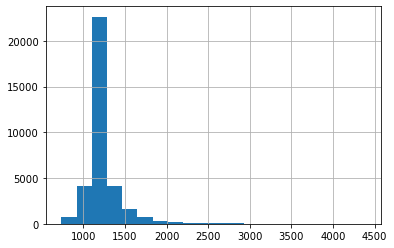

In [26]:
data["d_d"].hist(bins=20)

In [27]:
# Даты в старых форматах больше не нужны

data = data.drop(["first_date", "second_date"], axis=1)

<table>
    <tr>
        <td>
            <h2 align="center">Кухни, кухни ещё есть!</h2><br><br>
            <p>Точно, есть ещё кухни.</p>
            <p>Давайте выделим в отдельный признак их количество. 
            </p>
        </td>
    </tr>
</table>

<AxesSubplot:>

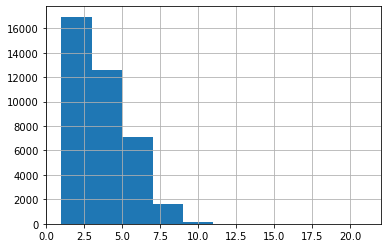

In [28]:
data["num_cus"] = data["Cuisine Style"].apply(
    lambda x: np.ceil(len(str(x).split("'"))/2)-1)
data["num_cus"] = data["num_cus"].replace(0, np.nan)

data["num_cus"].hist()

In [29]:
data.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,pol1,pol2,obj1,obj2,sen_sum1,sen_sum2,sen_mark1,sen_mark2,id_g,id_d,country,num_vis,capital,pop,gpd,temp,wage,d1,d2,d_d,num_cus
0,0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,2.0,194.0,0,0,0,0,0,0,0,0,0.0,1,Good food at your doorstep,A good hotel restaurant,0.700,0.700000,0.6,0.6,1.400000,4.200000,1.166667,3.500000,187147.0,1912643.0,France,17.7951,1.0,2.188,2.295,11.3,3084.0,5113.0,3976.0,1137.0,3.0
1,1,id_1535,Stockholm,NaN,1537,4.0,NaN,10.0,15,1054,2728,2,1,1,0,0,4.0,1,Unique cuisine,Delicious Nepalese food,0.375,1.000000,1.0,1.0,1.375000,2.750000,0.687500,1.375000,189852.0,7992032.0,Sweden,2.3423,1.0,1.553,0.480,7.0,2650.0,4935.0,3457.0,1478.0,NaN
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,3.0,688.0,992,919,16979,485,198,82,35,29,4.5,1,Catch up with friends,Not exceptional,0.000,-0.333333,0.0,1.0,-0.333333,-0.333333,-0.333333,-0.333333,186338.0,8632781.0,England,19.5565,1.0,8.797,2.500,11.1,2280.0,5121.0,4023.0,1098.0,7.0
3,3,id_3456,Berlin,NaN,3458,5.0,NaN,3.0,3,4639,5830,3,0,0,0,0,5.0,1,Empty,Empty,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,187323.0,1358776.0,Germany,5.4497,1.0,3.539,3.245,9.1,3750.0,NaN,NaN,NaN,NaN
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,2.0,84.0,178,650,2847,6,13,3,1,0,3.5,1,Best place to try a Bavarian food,Nice building but improvements need to be...,1.000,0.600000,0.3,1.0,1.600000,4.800000,1.230769,3.692308,187309.0,6864963.0,Germany,4.6583,0.0,1.464,3.245,8.0,3750.0,5070.0,3702.0,1368.0,3.0


<table>
    <tr>
        <td>
            <h2 align="center">Давайте посмотрим на "Number of Reviews".</h2><br><br>
            <p>Может, там пропуски есть.</p>
            <p>Может, мы их заполнить можем... 
            </p>
        </td>
    </tr>
</table>

In [30]:
pd.DataFrame(data["Number of Reviews"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Number of Reviews  46800 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


In [31]:
data[data["Number of Reviews"].isna()].head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,pol1,pol2,obj1,obj2,sen_sum1,sen_sum2,sen_mark1,sen_mark2,id_g,id_d,country,num_vis,capital,pop,gpd,temp,wage,d1,d2,d_d,num_cus
8,8,id_2690,Vienna,NaN,2692,4.0,NaN,NaN,1,3316,3739,0,1,0,0,0,4.0,1,Empty,Empty,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,190454.0,12845029.0,Austria,6.55015,1.0,1.868,0.370,9.9,2700.0,NaN,NaN,NaN,NaN
21,21,id_5844,Madrid,NaN,5847,4.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,1,Empty,Empty,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,187514.0,10058810.0,Spain,5.35005,1.0,6.477,1.162,13.7,1900.0,NaN,NaN,NaN,NaN
32,32,id_1327,Budapest,NaN,1328,5.0,NaN,NaN,1,2301,2750,1,0,0,0,0,5.0,1,"Absolutely amazing, tasty, fresh, cheap Ch...",Empty,0.433333,0.0,0.7,0.0,0.433333,0.866667,0.619048,1.238095,274887.0,8791087.0,Hungary,3.59140,1.0,1.752,0.126,11.0,763.0,4316.0,NaN,NaN,NaN
102,102,id_1409,Budapest,"['French', 'European', 'Hungarian']",1410,5.0,NaN,NaN,48,613,2750,17,6,0,1,1,4.5,1,Empty,Empty,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,274887.0,13197631.0,Hungary,3.59140,1.0,1.752,0.126,11.0,763.0,NaN,NaN,NaN,3.0
108,108,id_2047,Prague,"['Italian', 'Mediterranean']",2050,5.0,2.0,NaN,1,3603,4631,1,0,0,0,0,5.0,1,Empty,Empty,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,274707.0,12243659.0,Czech,7.37930,1.0,1.281,0.192,9.0,1146.0,NaN,NaN,NaN,2.0


<table>
    <tr>
        <td>
            <h2 align="center">А что это у графа Суворова заодно и "second_review" тут пустые?</h2><br><br>
            <p>Есть подозрение, что выполняется правило: "пустой "Number of Reviews" влечёт за собой<br>
                пустой "second_review".</p>
            <p>Проверим эту гипотезу. 
            </p>
        </td>
    </tr>
</table>

In [32]:
data_t = data[["Number of Reviews", "second_review"]].copy()
data_t = data_t[data_t["Number of Reviews"].isna()]

In [33]:
data_t["second_review"][data_t["second_review"].isna()]

Series([], Name: second_review, dtype: object)

In [34]:
# Убедились, что nan в этом слобце нет, это важно (и не могло быт по его построению, но на всякий случай)

random_temp_vector = np.random.randint(
    1, 100, len(data_t["Number of Reviews"]))
data_t["Number of Reviews"].fillna(pd.Series(random_temp_vector), inplace=True)
data_t["second_review"] = data_t["second_review"].replace(
    "Empty", np.nan).astype(float)
data_t["second_review"].fillna(pd.Series(random_temp_vector), inplace=True)
data_t.corr()

,Number of Reviews,second_review
Number of Reviews,1.0,1.0
second_review,1.0,1.0


<table>
    <tr>
        <td>
            <h2 align="center">Одно и то же, а, значит...</h2><br><br>
            <p>Отсутствиующее число отзывов и сопутствущий ему пустой столбец второго отзыва. Может быть,<br>
            дело в том, что отзыв - один?</p>
            <p>Проверим и эту гипотезу. 
            </p>
        </td>
    </tr>
</table>

In [35]:
data["Number of Reviews"].value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
4080.0       1
972.0        1
2036.0       1
1201.0       1
1543.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

In [36]:
# А единица-то где?

data["Number of Reviews"][data["Number of Reviews"] == 1]

Series([], Name: Number of Reviews, dtype: float64)

<AxesSubplot:>

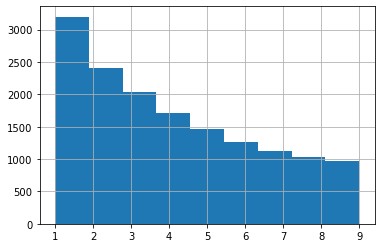

In [37]:
# А нет её. А что если все пустые значения и есть единицы?

data["Number of Reviews"].fillna(1, inplace=True)
data["Number of Reviews"][data["Number of Reviews"] < 10].hist(bins=9)

<table>
    <tr>
        <td>
            <h2 align="center">А эта версия имеет место на существование</h2><br><br>
            <p>В целом - похоже. Примем пока эту версию как рабочую.</p>
            <p>Посмотрим на данные. 
            </p>
        </td>
    </tr>
</table>

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50000 non-null  int64  
 1   Restaurant_id      50000 non-null  object 
 2   City               50000 non-null  object 
 3   Cuisine Style      38410 non-null  object 
 4   Ranking            50000 non-null  int64  
 5   Rating             40000 non-null  float64
 6   Price Range        32639 non-null  float64
 7   Number of Reviews  50000 non-null  float64
 8   new_rev            50000 non-null  int64  
 9   new_rank1          50000 non-null  int64  
 10  new_rank2          50000 non-null  int64  
 11  exellent           50000 non-null  int64  
 12  very_good          50000 non-null  int64  
 13  average            50000 non-null  int64  
 14  poor               50000 non-null  int64  
 15  terrible           50000 non-null  int64  
 16  new_rating         500

<table>
    <tr>
        <td>
            <h2 align="center">"Cuisine Style" нам не восполнить</h2><br><br>
            <p>Давайте посмотрим на "Price Range".</p>
            <p>Вдруг, что-то интересное.
            </p>
        </td>
    </tr>
</table>

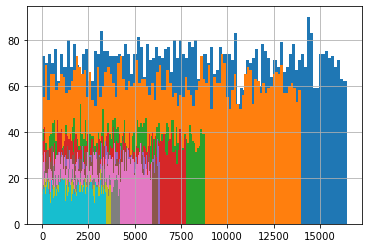

In [39]:
# Посмотрим на топ-10 городов, как советовали на видео
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

In [40]:
# Логичным шагом видится приведение Rank
data.append(pd.Series(name='rank_p', dtype="float64"))
data.append(pd.Series(name='num_r', dtype="float64"))
data["rank_p"] = 0.0
data["num_r"] = 0.0

cities = data["City"].value_counts().reset_index()

for i in range(0, len(data)):
    data.at[i, "rank_p"] = data.at[i, "Ranking"] / \
        cities["City"][cities["index"] == data.at[i, "City"]]
    data.at[i, "num_r"] = cities["City"][cities["index"] == data.at[i, "City"]]

In [41]:
# Введём ещё разные числовые параметры for the greater good

data["new_rank_p"] = data["new_rank1"] / data["new_rank2"]

data["num_r"] = data["rank_p"] * data["Number of Reviews"]
data["num_r_new"] = data["new_rank_p"] * data["new_rev"]

data["n1"] = data["exellent"] - data["very_good"]
data["n2"] = data["exellent"] - data["average"]
data["n3"] = data["exellent"] - data["poor"]
data["n4"] = data["exellent"] - data["terrible"]

data["n5"] = data["exellent"] * data["exellent"]
data["n6"] = data["very_good"] * data["very_good"]
data["n7"] = data["average"] * data["average"]
data["n8"] = data["poor"] * data["poor"]
data["n9"] = data["terrible"] * data["terrible"]

data["n10"] = data["n5"] - data["n6"]
data["n11"] = data["n5"] - data["n7"]
data["n12"] = data["n5"] - data["n8"]
data["n13"] = data["n5"] - data["n9"]

data["n14"] = data["exellent"]*data["very_good"] - \
    data["terrible"]*data["poor"]
data["n15"] = data["n5"]*data["very_good"] - data["n9"]*data["poor"]

data["n16"] = data["exellent"] / data["very_good"]
data["n17"] = data["exellent"] / data["average"]
data["n18"] = data["exellent"] / data["poor"]
data["n19"] = data["exellent"] / data["terrible"]
data[["n16", "n17", "n18", "n19"]] = data[[
    "n16", "n17", "n18", "n19"]].replace([np.inf, -np.inf], 0)
data[["n16", "n17", "n18", "n19"]] = data[[
    "n16", "n17", "n18", "n19"]].fillna(0)

data["n20"] = data["n5"] / data["n6"]
data["n21"] = data["n5"] / data["n7"]
data["n22"] = data["n5"] / data["n8"]
data["n23"] = data["n5"] / data["n9"]
data[["n20", "n21", "n22", "n23"]] = data[[
    "n20", "n21", "n22", "n23"]].replace([np.inf, -np.inf], 0)
data[["n20", "n21", "n22", "n23"]] = data[[
    "n20", "n21", "n22", "n23"]].fillna(0)

data["n24"] = (data["exellent"]+data["very_good"]) / \
    (data["terrible"]+data["poor"])
data["n25"] = data["exellent"] / (data["terrible"]+data["poor"])
data["n26"] = (data["exellent"]+data["very_good"]) / data["terrible"]
data[["n24", "n25", "n26"]] = data[[
    "n24", "n25", "n26"]].replace([np.inf, -np.inf], 0)
data[["n24", "n25", "n26"]] = data[["n24", "n25", "n26"]].fillna(0)

data["n27"] = data["exellent"] / data["new_rev"]
data["n28"] = data["very_good"] / data["new_rev"]
data["n29"] = data["average"] / data["new_rev"]
data["n30"] = data["poor"] / data["new_rev"]
data["n31"] = data["terrible"] / data["new_rev"]
data[["n27", "n28", "n29", "n30", "n31"]] = data[[
    "n27", "n28", "n29", "n30", "n31"]].replace([np.inf, -np.inf], 0)
data[["n27", "n28", "n29", "n30", "n31"]] = data[[
    "n27", "n28", "n29", "n30", "n31"]].fillna(0)

data["n32"] = (data["exellent"]+data["very_good"]) / data["new_rev"]
data["n33"] = (data["terrible"]+data["poor"]) / data["new_rev"]
data[["n32", "n33"]] = data[["n32", "n33"]].replace([np.inf, -np.inf], 0)
data[["n32", "n33"]] = data[["n32", "n33"]].fillna(0)

data["n34"] = data["new_rev"] / data["sen_sum2"]
data["n35"] = data["new_rev"] / data["sen_sum1"]
data["n36"] = (data["exellent"]+data["very_good"] -
               data["terrible"]-data["poor"]) / data["new_rev"]
data["n37"] = data["pop"] / data["num_vis"]
data[["n34", "n35", "n36", "n37"]] = data[[
    "n34", "n35", "n36", "n37"]].replace([np.inf, -np.inf], 0)
data[["n34", "n35", "n36", "n37"]] = data[[
    "n34", "n35", "n36", "n37"]].fillna(0)

n = data.columns.tolist()[45:82]

In [42]:
data.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,first_review,second_review,pol1,pol2,obj1,obj2,sen_sum1,...,n13,n14,n15,n16,n17,n18,n19,n20,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30,n31,n32,n33,n34,n35,n36,n37
0,0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,2.0,194.0,0,0,0,0,0,0,0,0,0.0,1,Good food at your doorstep,A good hotel restaurant,0.700,0.700000,0.6,0.6,1.400000,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122955
1,1,id_1535,Stockholm,NaN,1537,4.0,NaN,10.0,15,1054,2728,2,1,1,0,0,4.0,1,Unique cuisine,Delicious Nepalese food,0.375,1.000000,1.0,1.0,1.375000,...,4,2,4,2.000000,2.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.133333,0.066667,0.066667,0.000000,0.000000,0.200000,0.000000,5.454545,10.909091,0.200000,0.663024
2,2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,3.0,688.0,992,919,16979,485,198,82,35,29,4.5,1,Catch up with friends,Not exceptional,0.000,-0.333333,0.0,1.0,-0.333333,...,234384,95015,46545115,2.449495,5.914634,13.857143,16.724138,6.000026,34.982897,192.020408,279.69679,10.671875,7.578125,23.551724,0.488911,0.199597,0.082661,0.035282,0.029234,0.688508,0.064516,-2976.000000,-2976.000000,0.623992,0.449825
3,3,id_3456,Berlin,NaN,3458,5.0,NaN,3.0,3,4639,5830,3,0,0,0,0,5.0,1,Empty,Empty,0.000,0.000000,0.0,0.0,0.000000,...,9,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.649394
4,4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,2.0,84.0,178,650,2847,6,13,3,1,0,3.5,1,Best place to try a Bavarian food,Nice building but improvements need to be...,1.000,0.600000,0.3,1.0,1.600000,...,36,78,468,0.461538,2.000000,6.000000,0.000000,0.213018,4.000000,36.000000,0.00000,19.000000,6.000000,0.000000,0.033708,0.073034,0.016854,0.005618,0.000000,0.106742,0.005618,37.083333,111.250000,0.101124,0.314278


<table>
    <tr>
        <td>
            <h2 align="center">Посмотрим на корреляции до ввода dummy-переменных</h2><br><br>
            <p>Просто на вякий случай.
            </p>
        </td>
    </tr>
</table>

In [43]:
data.corr()

,Unnamed: 0,Ranking,Rating,Price Range,Number of Reviews,new_rev,new_rank1,new_rank2,exellent,very_good,average,poor,terrible,new_rating,sample,pol1,pol2,obj1,obj2,sen_sum1,sen_sum2,sen_mark1,sen_mark2,id_g,id_d,...,n13,n14,n15,n16,n17,n18,n19,n20,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30,n31,n32,n33,n34,n35,n36,n37
Unnamed: 0,1.000000,0.002561,0.000456,0.004937,-0.004031,-0.005982,0.002011,0.000438,-0.009437,-0.008494,-0.009171,-0.008096,-0.004796,0.000950,0.499422,0.001458,-0.001872,0.003479,-0.001141,-0.000250,0.000165,-0.001305,0.000022,0.002509,0.004524,...,-0.005664,-0.005748,-0.001166,-0.003038,-0.002240,0.001205,-0.004820,-0.004446,-0.005952,0.002601,-0.006177,0.000534,0.000530,-0.004507,-0.003335,0.001058,-0.003409,0.001581,0.002326,-0.001980,0.002581,-0.011454,-0.004625,-0.002942,-0.002971
Ranking,0.002561,1.000000,-0.368371,-0.103633,-0.223138,-0.215379,0.760365,0.499901,-0.170948,-0.159749,-0.101725,-0.068836,-0.005278,-0.159043,0.006271,-0.175898,-0.173157,-0.105858,-0.131410,-0.224809,-0.189135,-0.171883,-0.169835,-0.142415,0.049756,...,-0.043378,-0.037621,-0.010100,-0.138361,-0.193408,-0.194625,-0.193244,-0.031328,-0.070970,-0.073385,-0.071383,-0.225951,-0.208535,-0.209293,0.012586,0.112488,0.160500,0.175400,0.315781,0.070132,0.330234,0.001902,-0.002628,-0.064373,-0.051482
Rating,0.000456,-0.368371,1.000000,-0.022529,0.026934,0.041270,-0.264546,-0.037574,0.095918,0.025380,-0.025475,-0.056565,-0.137349,0.309155,NaN,0.223565,0.171206,0.074974,0.052548,0.254402,0.218816,0.224058,0.228095,0.006837,0.159111,...,0.024192,0.014036,0.002843,0.249093,0.191391,0.155410,0.158457,0.121904,0.088808,0.075143,0.070920,0.184149,0.196401,0.147722,0.376089,-0.023153,-0.243423,-0.290366,-0.444076,0.275159,-0.486152,-0.000296,0.001125,0.459849,-0.038935
Price Range,0.004937,-0.103633,-0.022529,1.000000,0.174248,0.148550,-0.059839,0.050389,0.138428,0.137383,0.137067,0.139339,0.107187,-0.029449,-0.004250,0.016134,0.040683,0.031819,0.065311,0.037582,0.024900,0.000322,-0.002982,-0.021051,-0.150458,...,0.053507,0.049575,0.021845,0.008343,0.028072,0.051142,0.076283,-0.016111,-0.011595,0.004508,0.021789,0.046500,0.039437,0.085605,-0.027650,-0.013280,0.020248,0.023658,-0.027211,-0.026540,-0.009362,0.000152,0.002741,-0.024349,-0.021397
Number of Reviews,-0.004031,-0.223138,0.026934,0.174248,1.000000,0.912858,-0.160042,0.067694,0.740859,0.753757,0.670801,0.611756,0.523760,0.065799,0.002686,0.106285,0.137585,0.101419,0.151649,0.156895,0.125764,0.113140,0.100350,-0.021366,-0.289865,...,0.454401,0.417361,0.229033,0.094515,0.194967,0.276250,0.318517,0.003502,0.049403,0.105518,0.166310,0.253389,0.236728,0.336962,0.003468,-0.035367,-0.037092,-0.023389,-0.057194,-0.016374,-0.055513,-0.003718,0.017062,0.006398,-0.047137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n33,0.002581,0.330234,-0.486152,-0.009362,-0.055513,-0.038321,0.365312,0.183129,-0.005190,0.034512,0.071731,0.125346,0.211489,-0.051967,-0.003397,-0.183020,-0.127959,-0.108892,-0.064069,-0.200556,-0.164056,-0.183371,-0.177954,-0.004213,-0.001141,...,-0.004157,0.001712,0.001442,-0.038982,-0.052001,-0.050852,-0.059526,-0.018125,-0.031125,-0.032432,-0.030798,-0.082118,-0.080816,-0.057636,0.063970,0.127054,0.178590,0.666992,0.864625,0.117249,1.000000,0.004301,0.001715,-0.286692,0.008545
n34,-0.011454,0.001902,-0.000296,0.000152,-0.003718,-0.000450,0.001207,0.004502,0.011774,0.001440,0.009173,0.013790,0.044886,-0.000189,-0.001247,0.001372,-0.003409,-0.001470,0.000648,-0.001287,-0.000496,-0.001513,-0.000532,-0.000752,0.001317,...,0.003536,0.002457,0.000377,0.001531,0.000387,-0.001088,-0.000920,-0.000253,-0.000284,-0.001049,-0.000258,-0.000932,-0.000686,-0.001321,0.003777,-0.000315,0.000595,0.000958,0.005006,0.002718,0.004301,1.000000,0.421594,0.000902,-0.000012
n35,-0.004625,-0.002628,0.001125,0.002741,0.017062,0.018165,-0.002004,0.00132

In [44]:
# Получим dummy-переменные по городам и странам

data = pd.get_dummies(data, columns=["City"], dummy_na=True)
data = pd.get_dummies(data, columns=["country"], dummy_na=True)
#data = pd.get_dummies(data, columns=[ 'Cuisine Style' ], dummy_na=True)

In [45]:
# Разберёмся с кухнями

data_cuisine_explode = data.copy()

u = "['Unknown']"
data_cuisine_explode = replace_nan(data_cuisine_explode, "Cuisine Style", [u])
data_cuisine_explode["Cuisine Style"] = data_cuisine_explode["Cuisine Style"].apply(
    literal_eval)

data = data_cuisine_explode

data_cuisine_explode = data_cuisine_explode.explode("Cuisine Style")

counts = data_cuisine_explode["Cuisine Style"].value_counts()
lst = counts[counts > 500].keys()

#d = create_dummies(data, "Cuisine Style", lst)

In [46]:
# Введём новые типы кухонь
meat = ["Barbecue", "Grill", "Steakhouse"]
asian = ["Asian", "Vietnamese", "Thai",
         "Chinese", "Sushi", "Japanese", "Korean"]
omfg = ["Vegetarian Friendly", "Vegan Options",
        "Gluten Free Options", "Healthy"]
drink = ["Wine Bar", "Bar", "Pub", "Brew Pub"]
unknown = ["Unknown"]
european = ["European", "Mediterranean", "Italian", "French", "Spanish", "British",
            "Central European", "Eastern European", "Czech", "Greek", "German",
            "Portuguese", "Austrian", "Polish", "Hungarian", "Irish", "Belgian",
            "Swiss", "Scottish", "Pizza"]
pizza = ["Pizza"]
eastern = ["Middle Eastern", "Turkish", "Halal", "Pakistani"]
exotic = ["Mexican", "Indian", "South American", "Bangladeshi", "Nepali",
          "Caribbean", "Peruvian", "Brazilian", "Central American", "Moroccan",
          "African", "Lebanese", "Argentinean"]
scandinavian = ["Scandinavian", "Dutch", "Danish", "Swedish"]
all_food_types = [meat, asian, omfg, drink, unknown,
                  european, pizza, eastern, exotic, scandinavian]
all_food_type_names = ["meat", "asian", "omfg", "drink", "unknown", "european", "pizza",
                       "eastern", "exotic", "scandinavian", "trash"]

# Инициализируем новые столбцы нулями
for food_type_name in all_food_type_names:
    data.append(pd.Series(name=food_type_name, dtype="float64"))
    data[food_type_name] = 0.0

for i in range(0, len(data)):
    j = 0
    for food_type in all_food_types:
        # Выбрали тип кухни
        for food in food_type:
            # Выбрали конкретную кухню
            if food in data.at[i, "Cuisine Style"]:
                data.at[i, all_food_type_names[j]] = 1
                found = 1
                break
        j += 1


data["trash"] = data["asian"] * data["pizza"]

In [47]:
city_cols = data.columns.tolist()[80:112]
# city_cols

In [48]:
country_cols = data.columns.tolist()[112:136]
# country_cols

In [49]:
lst = counts[counts >= 10].keys()
d = create_dummies(data, "Cuisine Style", lst)
c_cols = d.columns.tolist()[147:]
# c_cols

In [50]:
# Восстановим Price Range, создав модель

data_fna = data.fillna(data.mean())
data_train = data_fna.query('sample == 1').drop(['sample'], axis=1)

if (need_model == 1):

    stuff = [rank, rank_p, num_rev, num_r, id_g, id_d, city_s, num_cus,
             dates, new_rev, new_rank1, new_rank2, new_rank_p, num_r_new, mark,
             sen, city_cols, country_cols, all_food_type_names, c_cols, n]
    n_attempts = 3
    seed_v = np.random.randint(1e6, size=n_attempts)

    best_regr, X = search_best(
        data_train, stuff, "Price Range", "", "no need", n_attempts, seed_v, 100, 1, 0)

# 0.22

In [51]:
if (need_model == 1):

    data_test_isnull = data_fna[data["Price Range"].isnull()]

    y_pred = best_regr.predict(data_test_isnull[list(itertools.chain(*stuff))])

    data.loc[data["Price Range"].isnull(), "Price Range"] = y_pred

In [52]:
# Восстановим num_cus, создав модель

if (need_model == 1):

    stuff = [rank, rank_p, num_rev, num_r, id_g, id_d, city_s,
             dates, new_rev, new_rank1, new_rank2, new_rank_p, num_r_new, mark,
             sen, city_cols, country_cols, all_food_type_names, c_cols, n]
    n_attempts = 3
    seed_v = np.random.randint(1e6, size=n_attempts)

    best_regr, X = search_best(
        data_train, stuff, "num_cus", "", "no need", n_attempts, seed_v, 100, 1, 0)

# 0.24

In [53]:
if (need_model == 1):

    data_test_isnull = data_fna[data["num_cus"].isnull()]

    y_pred = best_regr.predict(data_test_isnull[list(itertools.chain(*stuff))])

    data.loc[data["num_cus"].isnull(), "num_cus"] = y_pred

In [54]:
# Восстановим d1, создав модель

if (need_model == 1):

    stuff = [rank, rank_p, num_rev, num_r, id_g, id_d, city_s,
             new_rev, new_rank1, new_rank2, new_rank_p, num_r_new, mark,
             sen, city_cols, country_cols, all_food_type_names, c_cols, n]
    n_attempts = 3
    seed_v = np.random.randint(1e6, size=n_attempts)

    best_regr, X = search_best(
        data_train, stuff, "d1", "", "no need", n_attempts, seed_v, 100, 1, 0)

# 132

In [55]:
if (need_model == 1):

    data_test_isnull = data_fna[data["d1"].isnull()]

    y_pred = best_regr.predict(data_test_isnull[list(itertools.chain(*stuff))])

    data.loc[data["d1"].isnull(), "d1"] = y_pred

In [56]:
# Восстановим d2, создав модель

if (need_model == 1):

    stuff = [rank, rank_p, num_rev, num_r, id_g, id_d, city_s,
             new_rev, new_rank1, new_rank2, new_rank_p, num_r_new, mark,
             sen, city_cols, country_cols, all_food_type_names, c_cols, n]
    n_attempts = 3
    seed_v = np.random.randint(1e6, size=n_attempts)

    best_regr, X = search_best(
        data_train, stuff, "d2", "", "no need", n_attempts, seed_v, 100, 1, 0)

# 116

In [57]:
if (need_model == 1):

    data_test_isnull = data_fna[data["d2"].isnull()]

    y_pred = best_regr.predict(data_test_isnull[list(itertools.chain(*stuff))])

    data.loc[data["d2"].isnull(), "d2"] = y_pred
    data["d_d"] = data["d1"] - data["d2"]

In [58]:
data_train = data.query('sample == 1').drop(['sample'], axis=1)

stuff = [rank, rank_p, p_range, num_rev, num_r, id_g, id_d, city_s, num_cus,
         dates, new_rev, new_rank1, new_rank2, new_rank_p, num_r_new, mark,
         sen, city_cols, country_cols, all_food_type_names, c_cols, n]

n_attempts = 3
seed_v = np.random.randint(1e6, size=n_attempts)

best_regr, X = search_best(data_train, stuff, "Rating",
                           "", "mean", n_attempts, seed_v, 100, 1, 0)
# 0.174

0. Тестируется ['Ranking', 'rank_p', 'Price Range', 'Number of Reviews', 'num_r', 'id_g', 'id_d', 'num_vis', 'capital', 'pop', 'gpd', 'temp', 'wage', 'num_cus', 'd1', 'd2', 'd_d', 'new_rev', 'new_rank1', 'new_rank2', 'new_rank_p', 'num_r_new', 'exellent', 'very_good', 'average', 'poor', 'terrible', 'pol1', 'pol2', 'obj1', 'obj2', 'sen_sum1', 'sen_sum2', 'sen_mark1', 'sen_mark2', 'City_Amsterdam', 'City_Athens', 'City_Barcelona', 'City_Berlin', 'City_Bratislava', 'City_Brussels', 'City_Budapest', 'City_Copenhagen', 'City_Dublin', 'City_Edinburgh', 'City_Geneva', 'City_Hamburg', 'City_Helsinki', 'City_Krakow', 'City_Lisbon', 'City_Ljubljana', 'City_London', 'City_Luxembourg', 'City_Lyon', 'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto', 'City_Oslo', 'City_Paris', 'City_Prague', 'City_Rome', 'City_Stockholm', 'City_Vienna', 'City_Warsaw', 'City_Zurich', 'City_nan', 'country_Austria', 'country_Belgium', 'country_Czech', 'country_Denmark', 'country_England', 'country_Finland', 'co

In [59]:
data_test = data.query('sample == 0').drop(
    ['sample'], axis=1).fillna(data.mean())
y_pred = best_regr.predict(data_test[list(itertools.chain(*stuff))])

In [60]:
data_test.append(pd.Series(name='pred', dtype="float64"))
data_test.append(pd.Series(name='pred_round', dtype="float64"))
data_test["pred"] = y_pred
data_test["pred_round"] = np.around(2*y_pred, 0)/2

data_test[["Restaurant_id", "pred_round"]].to_csv("pred.csv", index=False)

<AxesSubplot:>

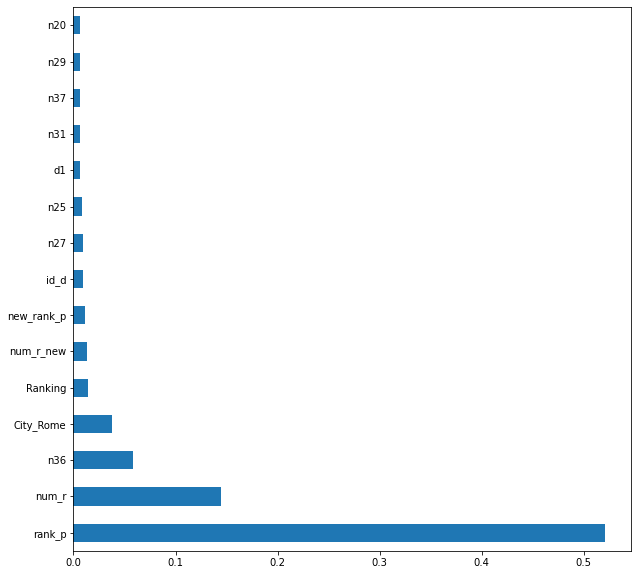

In [61]:
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(best_regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')